## Sharing our models on HuggingFace

In [1]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, \
                         DataCollatorWithPadding, TrainingArguments, Trainer, pipeline, \
                         AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import requests
import evaluate 

In [2]:
# ingest a new dataset classifying comments as being toxic or not
df = pd.read_csv("data/toxic.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


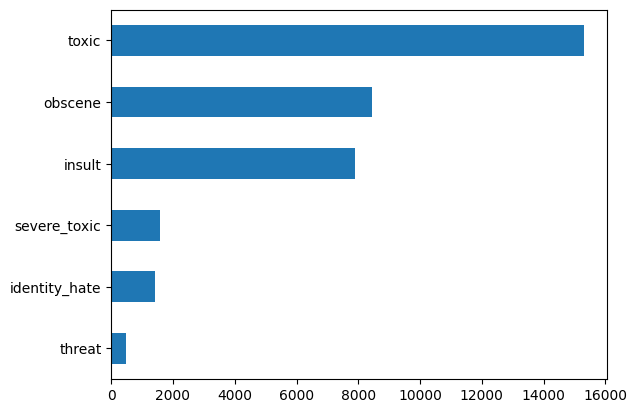

In [3]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

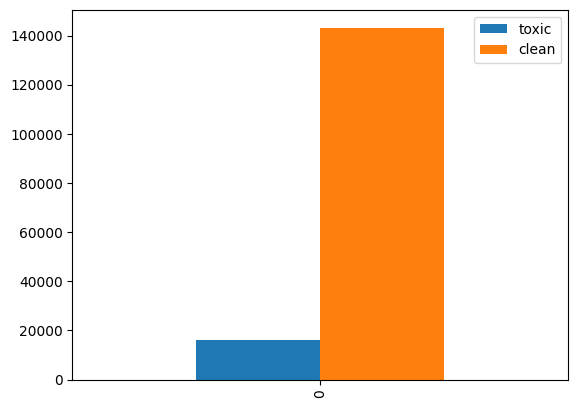

In [4]:
toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(toxic)], 
  clean=[len(clean)]
)).plot(kind='bar');

In [5]:
df = pd.concat([  # Take a hilariously small sample
  toxic.sample(50),
  clean.sample(50)
])

In [6]:
df['label'] = (df[LABEL_COLUMNS].sum(axis=1) > 0).astype(int)

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
133281,c90e2ed7285585d4,hahahahahahahahahahahahahaha \n\nyour signatur...,1,0,1,0,0,0,1
75313,c971eb8748315083,"Fuck off, before you give me the 'wikipedia is...",1,1,1,0,1,0,1
95938,0131902723bce44d,But before I block you I just wanna say that I...,1,0,1,0,0,0,1
20249,357b32ce9f0d5b2c,This Ghirlor is a fucking moron,1,1,1,0,1,0,1
43442,73ed47bf38df3c59,I have no idea what the hell you are talking a...,1,0,0,0,0,0,1


In [8]:
from datasets import Dataset
toxic_dataset = Dataset.from_pandas(df)
toxic_dataset = toxic_dataset.train_test_split(test_size=0.2)

In [9]:
bert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
sequence_classification_model.config.id2label = {0: 'Non-Toxic', 1: 'Toxic'}
sequence_classification_model.config.label2id = {'Non-Toxic': 0, 'Toxic': 1}

In [11]:
def preprocess(examples):
    return bert_tokenizer(examples['comment_text'], truncation=True)

In [12]:
toxic_dataset = toxic_dataset.map(preprocess)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [13]:
data_collator = DataCollatorWithPadding(bert_tokenizer)

In [14]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
import os
api_key = os.getenv('Hugging_Face_Key')
print(api_key)

# https://huggingface.co/Niel-77/Toxic-BERT
MODEL_IDENTIFIER = 'Niel-77/Toxic-BERT'

None


In [17]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./toxicity/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./toxicity/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    eval_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=sequence_classification_model,  # set both model and tokenizer to push to hub
    processing_class=bert_tokenizer,
    args=training_args,
    train_dataset=toxic_dataset['train'],
    eval_dataset=toxic_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [18]:
trainer.evaluate()

{'eval_loss': 0.6957275867462158,
 'eval_model_preparation_time': 0.0016,
 'eval_accuracy': 0.4,
 'eval_runtime': 0.3299,
 'eval_samples_per_second': 60.618,
 'eval_steps_per_second': 3.031}

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.676200,0.621693,0.001600,0.900000
2,0.612800,0.584792,0.001600,0.900000


TrainOutput(global_step=6, training_loss=0.6445476015408834, metrics={'train_runtime': 17.4014, 'train_samples_per_second': 9.195, 'train_steps_per_second': 0.345, 'total_flos': 15908506657344.0, 'train_loss': 0.6445476015408834, 'epoch': 2.0})

In [20]:
trainer.save_model()

In [ ]:
from huggingface_hub import create_repo

# repo_url = create_repo(repo_id="Toxic-BERT", private=True)
#Already Created

In [22]:
trainer.model.push_to_hub(
    use_auth_token=api_key,repo_id="Toxic-BERT"
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Niel-77/Toxic-BERT/commit/9a9e672b2548e53d7cb78fde54cfed60163c526d', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='9a9e672b2548e53d7cb78fde54cfed60163c526d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Niel-77/Toxic-BERT', endpoint='https://huggingface.co', repo_type='model', repo_id='Niel-77/Toxic-BERT'), pr_revision=None, pr_num=None)

In [23]:
trainer.tokenizer.push_to_hub(
    repo_id="Toxic-BERT", use_auth_token=api_key
)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Niel-77/Toxic-BERT/commit/9a9e672b2548e53d7cb78fde54cfed60163c526d', commit_message='Upload tokenizer', commit_description='', oid='9a9e672b2548e53d7cb78fde54cfed60163c526d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Niel-77/Toxic-BERT', endpoint='https://huggingface.co', repo_type='model', repo_id='Niel-77/Toxic-BERT'), pr_revision=None, pr_num=None)

## Example of online learning, continuing to train

In [24]:
# Load up our most recent version
auto_tokenizer = AutoTokenizer.from_pretrained(MODEL_IDENTIFIER)
auto_model = AutoModelForSequenceClassification.from_pretrained(MODEL_IDENTIFIER)

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [26]:
toxic_clf = pipeline(
    'text-classification',       
    model=auto_model,            
    tokenizer=auto_tokenizer,    
    use_fast=True,               # Use a fast tokenizer if possible
    top_k= None       # Return probabilities for all classes
)

Device set to use cuda:0


In [27]:
toxic_clf('you are a dumb dumb')

[[{'label': 'Toxic', 'score': 0.6073651909828186},
  {'label': 'Non-Toxic', 'score': 0.3926348090171814}]]

In [28]:
# Example of online learning with some more data

df = pd.concat([
  toxic.sample(100),
  clean.sample(100)
])

df['label'] = (df[LABEL_COLUMNS].sum(axis=1) > 0).astype(int)

new_toxic_dataset = Dataset.from_pandas(df)

new_toxic_dataset = new_toxic_dataset.map(preprocess)

new_toxic_dataset = new_toxic_dataset.train_test_split(test_size=0.2)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [29]:
batch_size = 32
epochs = 3

training_args = TrainingArguments(
    output_dir='./toxicity/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./toxicity/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    eval_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=auto_model,
    processing_class=auto_tokenizer,
    args=training_args,
    train_dataset=new_toxic_dataset['train'],
    eval_dataset=new_toxic_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [30]:
trainer.evaluate()

{'eval_loss': 0.5958132147789001,
 'eval_model_preparation_time': 0.0015,
 'eval_accuracy': 0.8,
 'eval_runtime': 0.1503,
 'eval_samples_per_second': 266.18,
 'eval_steps_per_second': 13.309}

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.539200,0.426722,0.001500,0.875000
2,0.357000,0.363658,0.001500,0.850000
3,0.225600,0.358350,0.001500,0.875000


TrainOutput(global_step=15, training_loss=0.37394227981567385, metrics={'train_runtime': 18.6963, 'train_samples_per_second': 25.673, 'train_steps_per_second': 0.802, 'total_flos': 53227056622464.0, 'train_loss': 0.37394227981567385, 'epoch': 3.0})

In [32]:
trainer.save_model()

In [33]:
trainer.model.push_to_hub(
    use_auth_token=api_key,repo_id="Toxic-BERT"
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Niel-77/Toxic-BERT/commit/5f8acc23aa6cf88787f159071ecd75b8fec81397', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='5f8acc23aa6cf88787f159071ecd75b8fec81397', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Niel-77/Toxic-BERT', endpoint='https://huggingface.co', repo_type='model', repo_id='Niel-77/Toxic-BERT'), pr_revision=None, pr_num=None)

In [35]:
trainer.processing_class.push_to_hub(
    use_auth_token=api_key,repo_id="Toxic-BERT"
)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Niel-77/Toxic-BERT/commit/f5a46634805657c73555c63ae99537fbf5ef1564', commit_message='Upload tokenizer', commit_description='', oid='f5a46634805657c73555c63ae99537fbf5ef1564', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Niel-77/Toxic-BERT', endpoint='https://huggingface.co', repo_type='model', repo_id='Niel-77/Toxic-BERT'), pr_revision=None, pr_num=None)

In [37]:
toxic_clf = pipeline(
    'text-classification',       # the type of NLP task
    MODEL_IDENTIFIER,            # the handle of our newly pushed model
    use_fast=True,               # Use a fast tokenizer if possible
    top_k=None       # Return probabilities for all classes
)

Device set to use cuda:0


In [38]:
toxic_clf('You are worse than dirt')

[[{'label': 'Toxic', 'score': 0.9146319031715393},
  {'label': 'Non-Toxic', 'score': 0.0853680670261383}]]

In [39]:
# API_URL = "https://api-inference.huggingface.co/models/Niel-77/Toxic-BERT"
# headers = {"Authorization": f"Bearer {api_key}"}

# def query(payload):
#     response = requests.post(API_URL, headers=headers, json=payload)
#     return response.json()

# # model goes to sleep when not used
# query({
#     "inputs": "you are a dumb dumb",
# })

##Requires payment to create inference endpoints

{'error': 'Authorization header is correct, but the token seems invalid'}